### Stock Predictions using XGboost

XGBoost, which stands for eXtreme Gradient Boosting, is a highly efficient and versatile implementation of the gradient boosting framework. It has become one of the most popular machine learning algorithms among data scientists, especially for structured or tabular data. XGBoost is known for its performance and speed, particularly in classification and regression predictive modeling problems.

PROS: High performance and accuracy, Can ber used for Regression and Classification, Built in function to handle missing data.  CONS: Complexity, Resource Intensive, Overfitting,Less effective on Non-Tabular data.

###  XGBoost with Sentiment Analysis


Using XGBoost for sentiment analysis in the context of predicting stock prices involves analyzing textual data (such as news headlines, financial reports, or social media posts) to gauge market sentiment and using that information as a predictive factor for stock movements. This approach is based on the hypothesis that sentiment from influential news sources or public opinion can have immediate effects on stock market performance.

In [1]:
import yfinance as yf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score,r2_score

In [2]:
stock = yf.Ticker("AAPL")
stock = stock.history(period='2y')


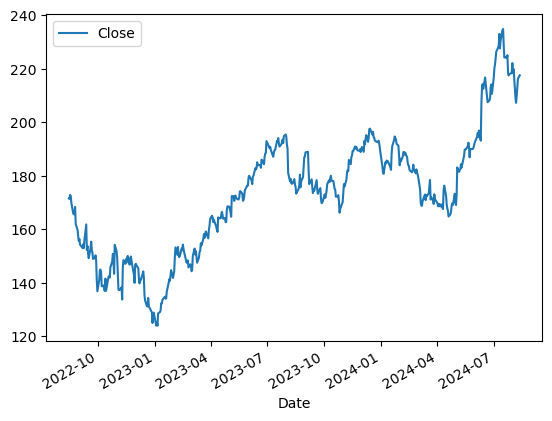

In [3]:
del stock['Dividends']
del stock['Stock Splits']
stock.plot.line(y="Close")
stock["Next Days Close"] = stock['Close'].shift(-1)
stock['change'] = (stock['Next Days Close'] > stock['Close']).astype(int)

In [4]:
# Drop rows with NaN target values
stock = stock.dropna(subset=['Next Days Close', 'change'])

# Split our preprocessed data into our features and target arrays
y = stock['change']
X = stock.drop(columns=['change'])

# Preserve the index of the original DataFrame
#original_index = X.index

In [5]:
#Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)
# Rebuild X_test DataFrame to restore index information
#X_test_df = pd.DataFrame(X_test, index=original_index[-len(X_test):], columns=X.columns)

In [7]:
# Check if X_train is defined
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')


X_train shape: (400, 6), y_train shape: (400,)


In [8]:
# Define the XGBoost model
model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)


In [9]:
# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)


In [10]:
# Evaluate the model
precision = precision_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
r_squared = r2_score(y_test, predictions)

# Display results
print(f'Precision: {precision}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'R-squared: {r_squared}')



Precision: 0.9166666666666666
Accuracy: 0.67
Recall: 0.5238095238095238
F1 Score: 0.6666666666666667
R-squared: -0.4157014157014156


Precision is the ratio of true positive predictions to the total number of positive predictions (both true and false positives).

Accuracy is the ratio of correct predictions (both true positives and true negatives) to the total number of predictions.Low accuracy suggests that the model isn't very reliable overall.

Recall (or sensitivity) is the ratio of true positive predictions to the total number of actual positives (true positives and false negatives).Low recall suggests that the model misses a significant number of actual stock price increases (high false negative rate).

F1 Score is the harmonic mean of precision and recall, providing a single metric that balances the two. It ranges from 0 to 1, where 1 indicates perfect precision and recall. However, given that both precision and recall are not very high, the F1 score reflects the model's overall mediocre performance.

R-squared (R²) measures the proportion of variance in the dependent variable (stock price change) that is predictable from the independent variables (features in your model). Negative R-squared values suggest that the model is not fitting the data well and may even be introducing more error than a simple average prediction.

In [11]:

# Combine actual values and predictions
predictions_df = pd.DataFrame(predictions, index=y_test.index, columns=['Predictions'])
combined = pd.concat([y_test, predictions_df], axis=1)

<Axes: title={'center': 'Actual vs. Predicted'}, xlabel='Date'>

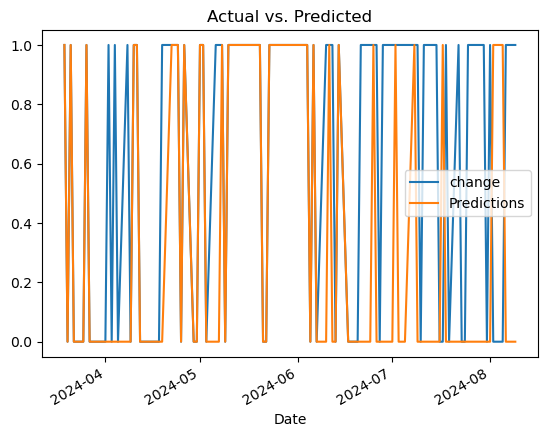

In [12]:

# Plot the combined DataFrame
combined.plot(title='Actual vs. Predicted')

In [13]:
# Make prediction for the next day
latest_data = X_scaled[-1].reshape(1, -1)
next_day_prediction = model.predict(latest_data)[0]

# Interpret the prediction
if next_day_prediction == 1:
    print("The model predicts that the stock price will increase the next day.")
else:
    print("The model predicts that the stock price will decrease the next day.")


The model predicts that the stock price will decrease the next day.


###   This is the XGboost code with SENTIMENT included 

In [14]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [15]:
def create_news_data(stock_df):
    # Ensure the date is in datetime format for consistency
    stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date
    
    # Creating a date range that covers all days in the stock data

    news_dates = pd.date_range(start=stock_df['Date'].min(), end=stock_df['Date'].max(), freq='D')
    headlines = [
        "Company reaches new heights", 
        "Company faces new challenges in the market", 
        "Company launches new product with success"
    ] * (len(news_dates) // 3 + 1)  # Repeat headlines to match the length
  
    # Create the news DataFrame
    news = pd.DataFrame({
        'date': news_dates,
        'headline': headlines[:len(news_dates)]
    })
    news['date'] = pd.to_datetime(news['date']).dt.date
    
    print("Returning DataFrame:", news.head())  # Print the DataFrame being returned
    
    return news
    

In [16]:
# Fetch stock data
ticker = "AAPL"  # Change this ticker to analyze a different stock
stock = yf.Ticker(ticker)
df = stock.history(period='2y')
df.reset_index(inplace=True, drop=False)
df['Date'] = pd.to_datetime(df['Date']).dt.date

In [17]:
# Generate news data dynamically based on the stock data
news = create_news_data(df)

#print(news['headline'].isnull().any())


Returning DataFrame:          date                                    headline
0  2022-08-15                 Company reaches new heights
1  2022-08-16  Company faces new challenges in the market
2  2022-08-17   Company launches new product with success
3  2022-08-18                 Company reaches new heights
4  2022-08-19  Company faces new challenges in the market


In [18]:
# Perform sentiment analysis
analyzer = SentimentIntensityAnalyzer()
news['sentiment'] = news['headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])


In [19]:
# Merge stock data with sentiment data
full_data = pd.merge(df, news, left_on='Date', right_on='date', how='left')
full_data['sentiment'].fillna(0, inplace=True)  # Fill missing sentiment values with neutral (0)


In [20]:
# Prepare features and target for the model
full_data['Next Day Close'] = full_data['Close'].shift(-1)
full_data['Change'] = (full_data['Next Day Close'] > full_data['Close']).astype(int)
full_data.dropna(inplace=True)


In [21]:
X = full_data[['Open', 'High', 'Low', 'Close', 'Volume', 'sentiment']]
y = full_data['Change']


In [22]:
# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [23]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)



In [24]:
# Initialize and train XGBClassifier
model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model.fit(X_train, y_train)

/Users/keycaughey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:32:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [25]:
# Predictions and evaluation
predictions = model.predict(X_test)
precision = precision_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
r_squared = r2_score(y_test, predictions)

# Print performance metrics
print(f'Precision: {precision}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'R-squared: {r_squared}')

Precision: 0.5675675675675675
Accuracy: 0.42
Recall: 0.3333333333333333
F1 Score: 0.42
R-squared: -1.488202488202488


In [26]:
model.predict_proba(X_test)

array([[0.04407328, 0.9559267 ],
       [0.7468624 , 0.25313762],
       [0.15344048, 0.8465595 ],
       [0.16297013, 0.8370299 ],
       [0.03953654, 0.96046346],
       [0.5828432 , 0.41715682],
       [0.896239  , 0.10376102],
       [0.2591743 , 0.7408257 ],
       [0.25301415, 0.74698585],
       [0.82856673, 0.17143327],
       [0.4674852 , 0.5325148 ],
       [0.3764475 , 0.6235525 ],
       [0.6230968 , 0.37690318],
       [0.97164035, 0.02835965],
       [0.85844797, 0.14155203],
       [0.8211322 , 0.17886779],
       [0.71095884, 0.28904113],
       [0.48903757, 0.5109624 ],
       [0.45183355, 0.54816645],
       [0.42363006, 0.57636994],
       [0.23739886, 0.76260114],
       [0.6898192 , 0.31018075],
       [0.46798402, 0.532016  ],
       [0.88710046, 0.11289953],
       [0.18416113, 0.8158389 ],
       [0.8802123 , 0.1197877 ],
       [0.1041891 , 0.8958109 ],
       [0.6316204 , 0.36837962],
       [0.6143918 , 0.38560817],
       [0.4116317 , 0.5883683 ],
       [0.

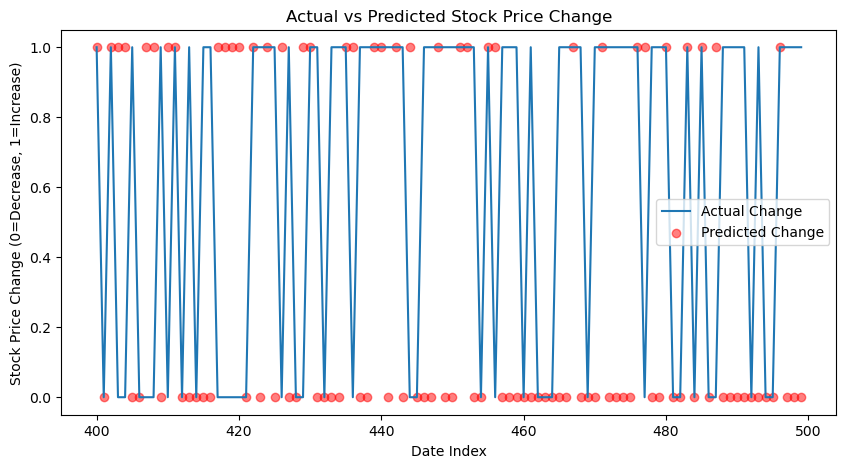

In [27]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual Change')
plt.scatter(y_test.index, predictions, color='red', label='Predicted Change', alpha=0.5)
plt.title('Actual vs Predicted Stock Price Change')
plt.xlabel('Date Index')
plt.ylabel('Stock Price Change (0=Decrease, 1=Increase)')
plt.legend()
plt.show()

In [28]:
# Combine actual values and predictions
predictions_df = pd.DataFrame(predictions, index=y_test.index, columns=['Predictions'])
combined = pd.concat([y_test, predictions_df], axis=1)

In [29]:
combined.head()

,Change,Predictions
400,1,1
401,0,0
402,1,1
403,0,1
404,0,1


In [30]:
len(combined[combined["Change"] == combined["Predictions"]]) / len(combined)

0.42

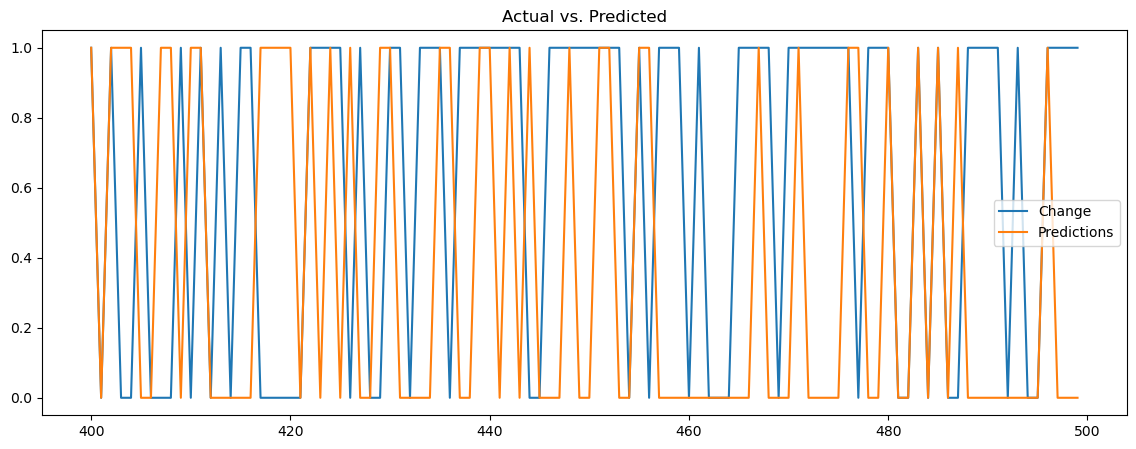

In [31]:
# Plot the combined DataFrame

combined.plot(title='Actual vs. Predicted', figsize=(14,5))
plt.plot();

In [32]:
# Make prediction for the next day
latest_data = X_scaled[-1].reshape(1, -1)
next_day_prediction = model.predict(latest_data)[0]

# Interpret the prediction
if next_day_prediction == 1:
    print("The model predicts that the stock price will increase the next day.")
else:
    print("The model predicts that the stock price will decrease the next day.")


The model predicts that the stock price will decrease the next day.
